# Stock Price Prediction with LSTM: A Practical Approach

Stock price prediction is crucial for businesses and investors as it supports decision-making in areas such as portfolio management, risk assessment, and investment planning. Accurate forecasts help businesses optimize resource allocation, evaluate potential risks, and identify market opportunities. For investors, reliable stock predictions enable better timing for buying or selling stocks, improving returns and mitigating losses.


The dataset contains daily closing prices for Apple stocks from 2010 to the present. This historical data serves as the foundation for training our LSTM model, enabling it to learn patterns and trends such as market volatility, seasonal effects, or other recurring behaviors that influence stock prices.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU, Bidirectional
import yfinance as yf

In [5]:
df = yf.download('AAPL', start='2010-01-01')[['Close']]
df.reset_index(inplace=True)
df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Date,Close
Ticker,,AAPL
0,2010-01-04,6.440331
1,2010-01-05,6.451466
2,2010-01-06,6.348847
3,2010-01-07,6.337109
4,2010-01-08,6.379241
...,...,...
3801,2025-02-12,236.869995
3802,2025-02-13,241.529999
3803,2025-02-14,244.600006


In [6]:
df.columns=['Date','Close']

## Descriptive Analysis

In [8]:
# Convert the 'date' column to a datetime object (if not already)
df['date'] = pd.to_datetime(df['Date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Descriptive analysis
print("Descriptive Statistics of Close Price:")
print(df['Close'].describe())

# Checking for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Descriptive Statistics of Close Price:
count    3806.000000
mean       68.927713
std        67.090558
min         5.779476
25%        17.574206
50%        35.849552
75%       128.903336
max       258.735504
Name: Close, dtype: float64

Missing Values:
Date     0
Close    0
dtype: int64


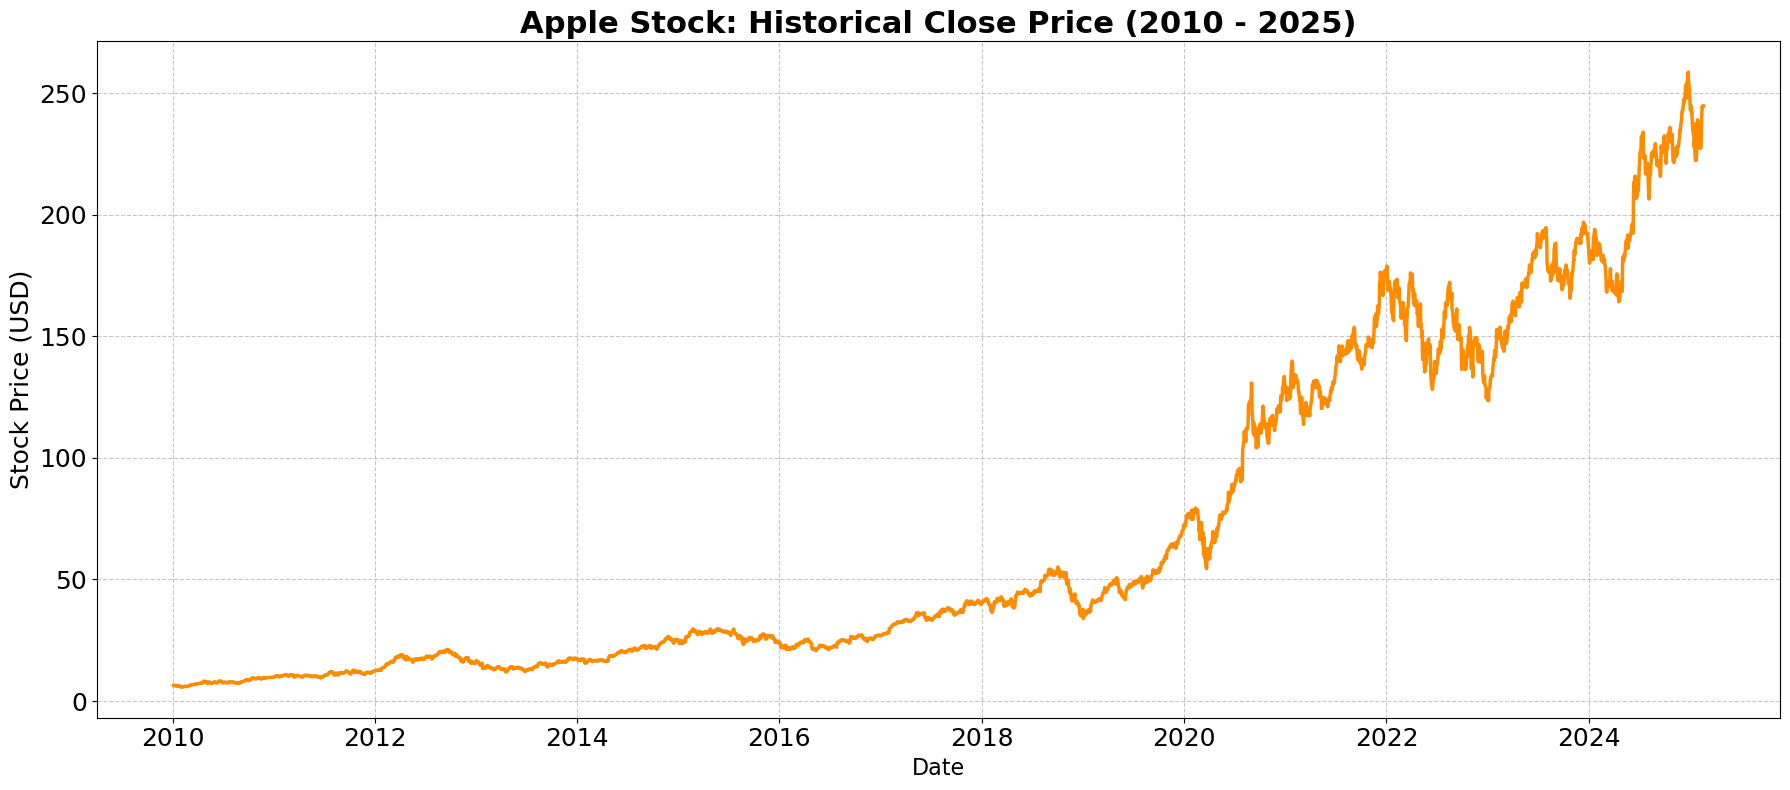

In [9]:
# Plotting the time series
plt.figure(figsize=(18, 8))
plt.plot(df['Close'], label='Close Price', color='darkorange', linewidth=2.5)
plt.title('Apple Stock: Historical Close Price (2010 - 2025)', fontsize=22, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Stock Price (USD)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Dataset Generation

In [11]:
def create_lstm_dataframe(series, window_size, step_ahead):
    """
    Creates a DataFrame for LSTM training from a time series.

    Parameters:
        series (array-like): The time series data.
        window_size (int): The size of the time window for inputs.
        step_ahead (int): The number of steps ahead to predict

    Returns:
        X, y: Arrays of inputs and outputs for LSTM training.
    """
    X, y = [], []  # Initialize empty lists for inputs (X) and outputs (y)

    # Loop through the series to create sequences of inputs and outputs
    for i in range(len(series) - window_size - step_ahead + 1):
        # Extract a window of size 'window_size' as input
        X.append(series[i:i + window_size])

        # Extract the target value(s) 'step_ahead' steps ahead as output
        y.append(series[i + window_size:i + window_size + step_ahead])

    # Convert the lists to NumPy arrays for compatibility with LSTM models
    return np.array(X), np.array(y)

# Set the parameters
window_size = 60  # Number of days to use as input
step_ahead = 1    # Predicting 1 day ahead

# Create the inputs and outputs for LSTM
sales_series = df['Close'].values  # Convert the sales column to a NumPy array
X, y = create_lstm_dataframe(sales_series, window_size, step_ahead)

# Display the shape of the generated data
print(f"Shape of X (inputs): {X.shape}")
print(f"Shape of y (outputs): {y.shape}")

Shape of X (inputs): (3746, 60)
Shape of y (outputs): (3746, 1)


In [12]:
X

array([[  6.44033098,   6.45146561,   6.34884691, ...,   6.94861221,
          6.99345112,   7.0975771 ],
       [  6.45146561,   6.34884691,   6.33710909, ...,   6.99345112,
          7.0975771 ,   7.07199526],
       [  6.34884691,   6.33710909,   6.37924099, ...,   7.0975771 ,
          7.07199526,   7.10118484],
       ...,
       [224.75288391, 227.76957703, 228.02928162, ..., 232.61999512,
        236.86999512, 241.52999878],
       [227.76957703, 228.02928162, 228.74848938, ..., 236.86999512,
        241.52999878, 244.6000061 ],
       [228.02928162, 228.74848938, 228.26902771, ..., 241.52999878,
        244.6000061 , 244.47000122]])

In [13]:
y

array([[  7.07199526],
       [  7.10118484],
       [  7.1770215 ],
       ...,
       [244.6000061 ],
       [244.47000122],
       [244.82499695]])

## Data Preparation

In [15]:
# Define the split point
split_index = int(len(X) * 0.8)  # 80% for training, 20% for testing

# Split the data manually
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
X_train

array([[  6.44033098,   6.45146561,   6.34884691, ...,   6.94861221,
          6.99345112,   7.0975771 ],
       [  6.45146561,   6.34884691,   6.33710909, ...,   6.99345112,
          7.0975771 ,   7.07199526],
       [  6.34884691,   6.33710909,   6.37924099, ...,   7.0975771 ,
          7.07199526,   7.10118484],
       ...,
       [158.25090027, 158.63417053, 159.15507507, ..., 166.18721008,
        170.0348053 , 169.79866028],
       [158.63417053, 159.15507507, 154.11328125, ..., 170.0348053 ,
        169.79866028, 166.18721008],
       [159.15507507, 154.11328125, 157.48429871, ..., 169.79866028,
        166.18721008, 164.63241577]])

In [16]:
X_test

array([[154.11328125, 157.48429871, 162.45727539, ..., 166.18721008,
        164.63241577, 161.69992065],
       [157.48429871, 162.45727539, 161.93637085, ..., 164.63241577,
        161.69992065, 157.51766968],
       [162.45727539, 161.93637085, 160.9437561 , ..., 161.69992065,
        157.51766968, 160.14508057],
       ...,
       [224.75288391, 227.76957703, 228.02928162, ..., 232.61999512,
        236.86999512, 241.52999878],
       [227.76957703, 228.02928162, 228.74848938, ..., 236.86999512,
        241.52999878, 244.6000061 ],
       [228.02928162, 228.74848938, 228.26902771, ..., 241.52999878,
        244.6000061 , 244.47000122]])

In [17]:
# Initialize scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))  # For input data
scaler_y = MinMaxScaler(feature_range=(0, 1))  # For output data

# Fit the scaler on the training data and transform
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_scaled = scaler_y.fit_transform(y_train)

# Transform the test data using the same scalers
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test_scaled = scaler_y.transform(y_test)
X_train_scaled

array([[4.30873813e-03, 4.38133523e-03, 3.71226731e-03, ...,
        0.00000000e+00, 0.00000000e+00, 1.48897904e-04],
       [4.38133523e-03, 3.71226731e-03, 3.63573738e-03, ...,
        2.60795498e-04, 6.05783518e-04, 0.00000000e+00],
       [3.71226731e-03, 3.63573738e-03, 3.91043493e-03, ...,
        8.66421031e-04, 4.56953653e-04, 1.69896647e-04],
       ...,
       [9.94104833e-01, 9.96603733e-01, 1.00000000e+00, ...,
        9.26175810e-01, 9.48541069e-01, 9.47143073e-01],
       [9.96603733e-01, 1.00000000e+00, 9.67127797e-01, ...,
        9.48554489e-01, 9.47167226e-01, 9.26122793e-01],
       [1.00000000e+00, 9.67127797e-01, 9.89106635e-01, ...,
        9.47181005e-01, 9.26156552e-01, 9.17073184e-01]])

In [18]:
# Reshape the input data to match the LSTM input requirements (samples, time steps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Display the shapes of the prepared data
print(f"X_train shape: {X_train_scaled.shape}")
print(f"y_train shape: {y_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")
print(f"y_test shape: {y_test_scaled.shape}")

X_train shape: (2996, 60, 1)
y_train shape: (2996, 1)
X_test shape: (750, 60, 1)
y_test shape: (750, 1)


## Simple RNN Prediction

In [20]:
# Define the RNN model
model_rnn = Sequential([
    SimpleRNN(32, activation='tanh', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dense(1)  # Output layer for regression (predicting a continuous value)
])

# Compile the model
model_rnn.compile(optimizer='adam', loss='mse', metrics=['mae'])


C:\Users\34636\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train the RNN model
history = model_rnn.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=40,
    batch_size=64,
    verbose=1
)

Epoch 1/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0588 - mae: 0.1134 - val_loss: 0.0411 - val_mae: 0.1565
Epoch 2/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.2494e-04 - mae: 0.0167 - val_loss: 0.0299 - val_mae: 0.1291
Epoch 3/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.5238e-04 - mae: 0.0134 - val_loss: 0.0256 - val_mae: 0.1197
Epoch 4/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.2046e-04 - mae: 0.0114 - val_loss: 0.0215 - val_mae: 0.1091
Epoch 5/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.7046e-04 - mae: 0.0100 - val_loss: 0.0172 - val_mae: 0.0956
Epoch 6/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.1548e-04 - mae: 0.0089 - val_loss: 0.0133 - val_mae: 0.0817
Epoch 7/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.1699e-04 - mae: 0.0087 - val_loss: 0.0128 - val_mae: 0.0820
Epoch 8/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.8342e-04 - mae: 0.0082 - val_loss: 0.0133 - val_mae: 0.0871
Epoch 9/40
47/47 ━━━━━━━━━━━━━━━━━━━

In [23]:
# Evaluate the model on the test set
test_loss, test_mae = model_rnn.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss (MSE): 0.0019
Test MAE: 0.0314


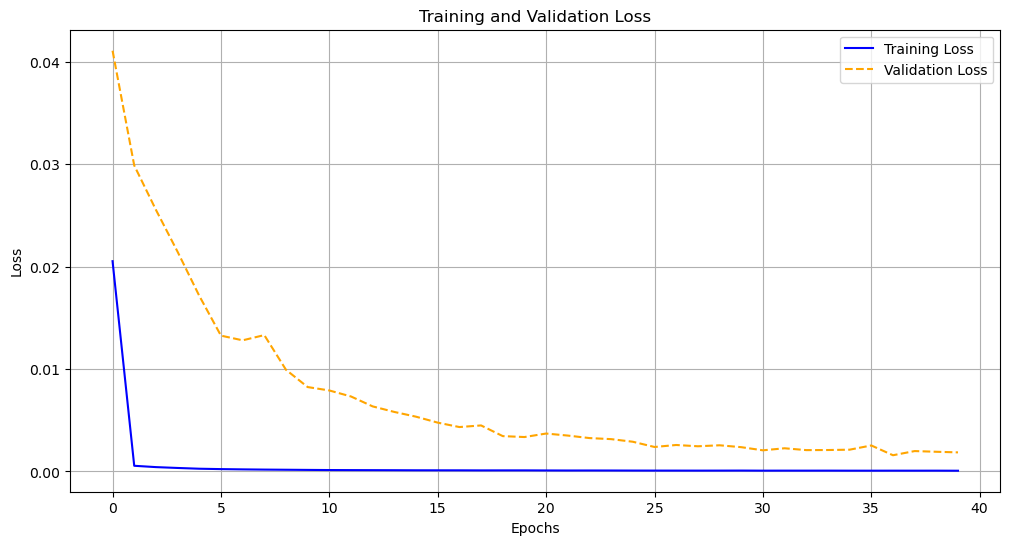

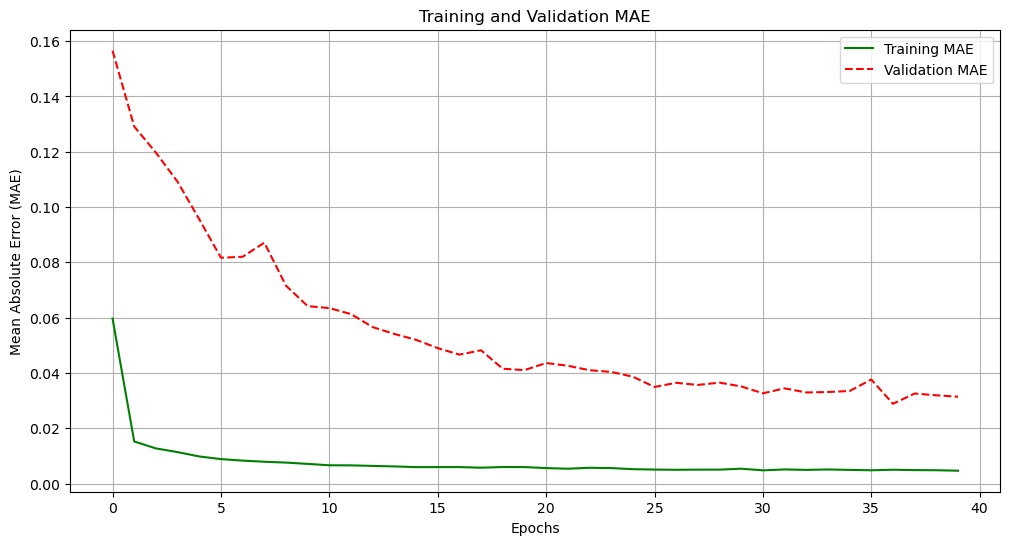

In [24]:
# Obtener los valores de pérdida (loss) y MAE (Mean Absolute Error) del entrenamiento y validación
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

# Crear la gráfica de pérdida
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', linestyle='--', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Crear la gráfica de MAE
plt.figure(figsize=(12, 6))
plt.plot(mae, label='Training MAE', color='green')
plt.plot(val_mae, label='Validation MAE', linestyle='--', color='red')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Make predictions on the training set
y_train_pred_scaled = model_rnn.predict(X_train_scaled)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)

# Make predictions on the test set
y_test_pred_scaled = model_rnn.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

# Inverse transform the original values
y_train_original = scaler_y.inverse_transform(y_train_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Combine train and test predictions for visualization
train_time_steps = range(len(y_train_original))
test_time_steps = range(len(y_train_original), len(y_train_original) + len(y_test_original))


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


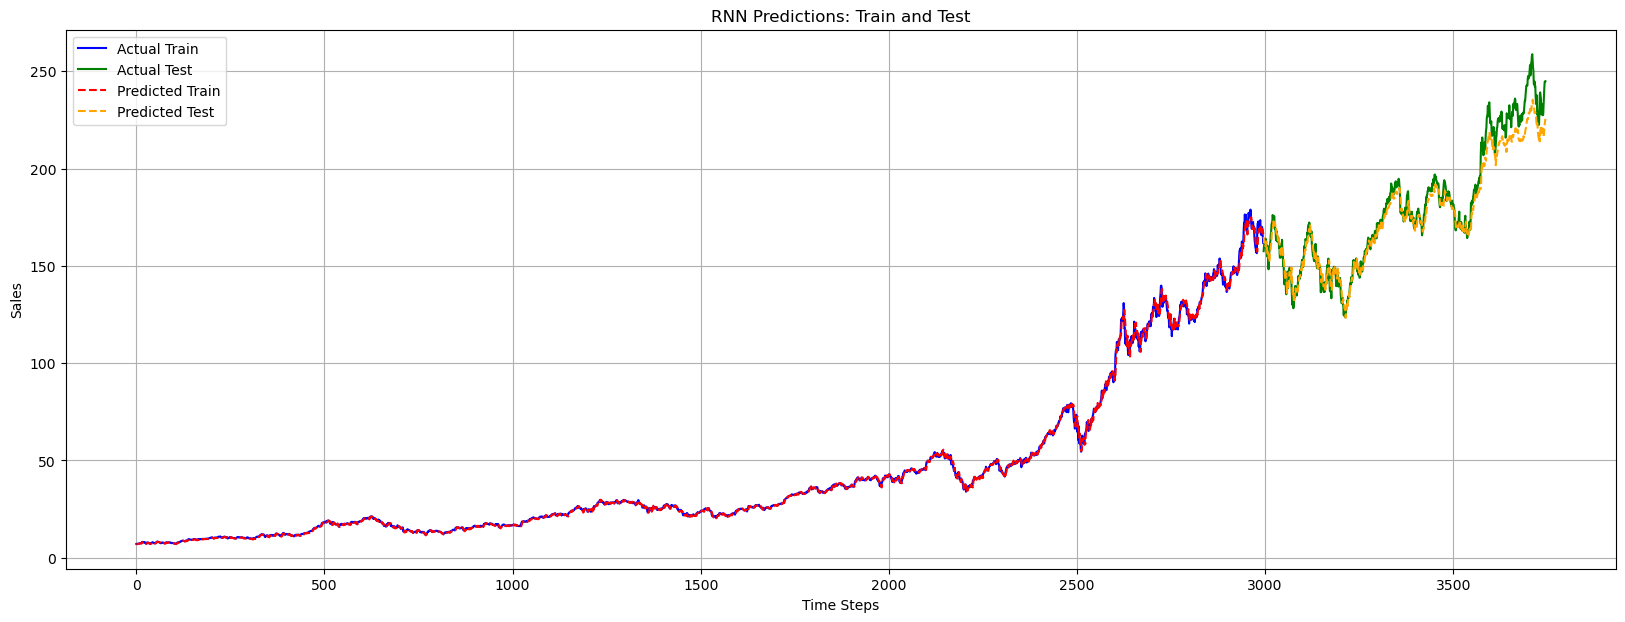

In [26]:

plt.figure(figsize=(20, 7))

# Plot actual values
plt.plot(train_time_steps, y_train_original, label="Actual Train", color="blue")
plt.plot(test_time_steps, y_test_original, label="Actual Test", color="green")

# Plot predictions
plt.plot(train_time_steps, y_train_pred, label="Predicted Train", color="red", linestyle="--")
plt.plot(test_time_steps, y_test_pred, label="Predicted Test", color="orange", linestyle="--")

# Customize the plot
plt.title("RNN Predictions: Train and Test")
plt.xlabel("Time Steps")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()

In [27]:
# Define functions to calculate MAPE, MAE, and RMSE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Calculate metrics for training data
mape_train = calculate_mape(y_train_original, y_train_pred)
mae_train = calculate_mae(y_train_original, y_train_pred)
rmse_train = calculate_rmse(y_train_original, y_train_pred)

# Calculate metrics for test data
mape_test = calculate_mape(y_test_original, y_test_pred)
mae_test = calculate_mae(y_test_original, y_test_pred)
rmse_test = calculate_rmse(y_test_original, y_test_pred)

# Create a comparative table
metrics_data = {
    "Dataset": ["Train", "Test"],
    "MAPE (%)": [mape_train, mape_test],
    "MAE": [mae_train, mae_test],
    "RMSE": [rmse_train, rmse_test]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df

,Dataset,MAPE (%),MAE,RMSE
0,Train,1.836397,0.752099,1.373017
1,Test,2.771315,5.398296,7.406807


## LSTM Prediction

In [29]:
# Define the LSTM model
model_lstm = Sequential([
    LSTM(32, activation='tanh', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),  # First LSTM layer
    Dense(1)  # Output layer
])
# Compile the model
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])


C:\Users\34636\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the model
history_lstm = model_lstm.fit(
    X_train_scaled, y_train_scaled,  # Training data
    validation_data=(X_test_scaled, y_test_scaled),  # Validation data
    epochs=40,  # Number of epochs
    batch_size=32,  # Batch size
    verbose=1  # Display progress
)

Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0348 - mae: 0.1015 - val_loss: 0.0029 - val_mae: 0.0423
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.8652e-04 - mae: 0.0116 - val_loss: 0.0052 - val_mae: 0.0547
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.2692e-04 - mae: 0.0093 - val_loss: 0.0048 - val_mae: 0.0527
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.1031e-04 - mae: 0.0086 - val_loss: 0.0055 - val_mae: 0.0572
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0203e-04 - mae: 0.0086 - val_loss: 0.0040 - val_mae: 0.0487
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.0857e-04 - mae: 0.0084 - val_loss: 0.0032 - val_mae: 0.0438
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.9804e-04 - mae: 0.0083 - val_loss: 0.0035 - val_mae: 0.0459
Epoch 8/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.7126e-04 - mae: 0.0077 - val_loss: 0.0058 - val_mae: 0.0621
Epoch 9/40
94/94 ━━━━━━━━━━━━━━━━━━━

In [32]:
# Evaluate the model on the test set
test_loss, test_mae = model_lstm.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss (MSE): 0.0009
Test MAE: 0.0244


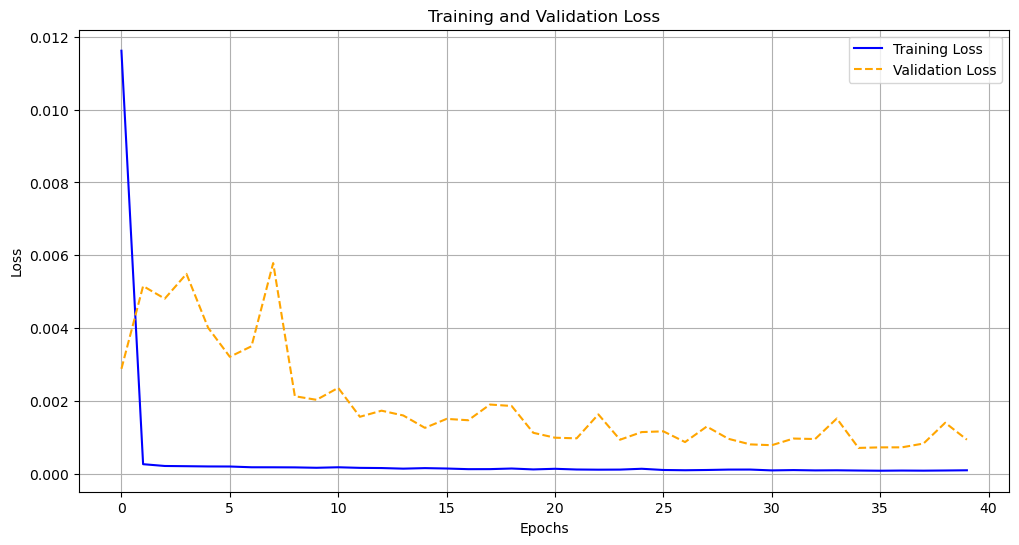

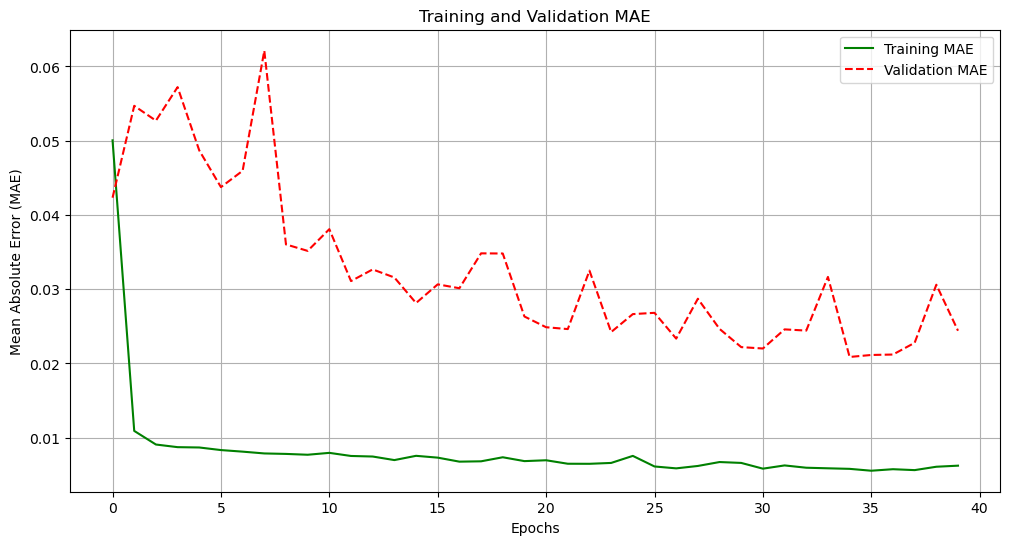

In [33]:
# Obtener los valores de pérdida (loss) y MAE (Mean Absolute Error) del entrenamiento y validación
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
mae = history_lstm.history['mae']
val_mae = history_lstm.history['val_mae']

# Crear la gráfica de pérdida
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', linestyle='--', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Crear la gráfica de MAE
plt.figure(figsize=(12, 6))
plt.plot(mae, label='Training MAE', color='green')
plt.plot(val_mae, label='Validation MAE', linestyle='--', color='red')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# Make predictions on the training set
y_train_pred_scaled = model_lstm.predict(X_train_scaled)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)

# Make predictions on the test set
y_test_pred_scaled = model_lstm.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

# Inverse transform the original values
y_train_original = scaler_y.inverse_transform(y_train_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Combine train and test predictions for visualization
train_time_steps = range(len(y_train_original))
test_time_steps = range(len(y_train_original), len(y_train_original) + len(y_test_original))


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


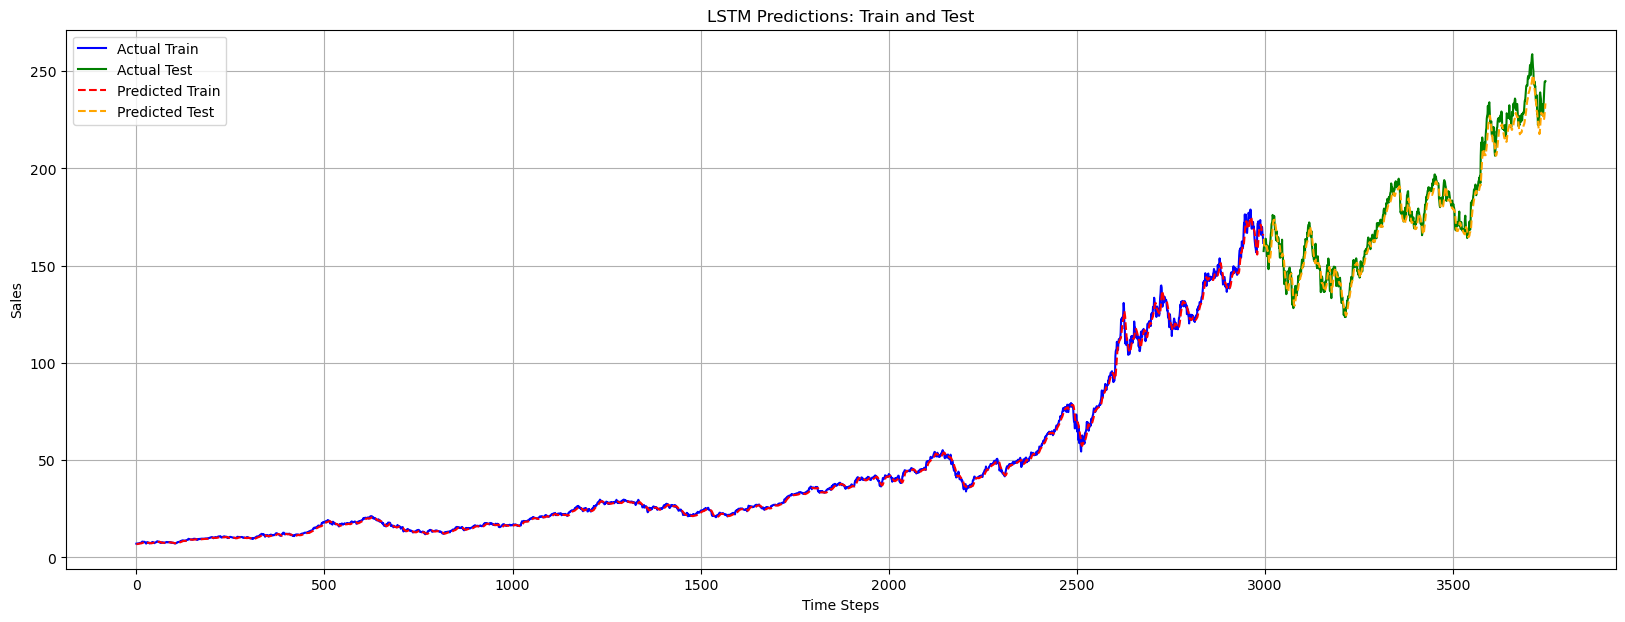

In [35]:
plt.figure(figsize=(20, 7))

# Plot actual values
plt.plot(train_time_steps, y_train_original, label="Actual Train", color="blue")
plt.plot(test_time_steps, y_test_original, label="Actual Test", color="green")

# Plot predictions
plt.plot(train_time_steps, y_train_pred, label="Predicted Train", color="red", linestyle="--")
plt.plot(test_time_steps, y_test_pred, label="Predicted Test", color="orange", linestyle="--")

# Customize the plot
plt.title("LSTM Predictions: Train and Test")
plt.xlabel("Time Steps")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()

In [36]:
# Calculate metrics for training data
mape_train_lstm = calculate_mape(y_train_original, y_train_pred)
mae_train_lstm = calculate_mae(y_train_original, y_train_pred)
rmse_train_lstm = calculate_rmse(y_train_original, y_train_pred)

# Calculate metrics for test data
mape_test_lstm = calculate_mape(y_test_original, y_test_pred)
mae_test_lstm = calculate_mae(y_test_original, y_test_pred)
rmse_test_lstm = calculate_rmse(y_test_original, y_test_pred)

# Create a comparative table
metrics_data = {
    "Dataset": ["Train", "Test"],
    "MAPE (%)": [mape_train_lstm, mape_test_lstm],
    "MAE": [mae_train_lstm, mae_test_lstm],
    "RMSE": [rmse_train_lstm, rmse_test_lstm]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df

,Dataset,MAPE (%),MAE,RMSE
0,Train,2.443406,0.954626,1.64471
1,Test,2.296474,4.193285,5.28498


## GRU Prediction

In [41]:
# Define the GRU model
model_gru = Sequential([
    GRU(32, activation='tanh', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),  # First GRU layer
    Dense(1)  # Output layer
])

# Compile the model
model_gru.compile(optimizer='adam', loss='mse', metrics=['mae'])


C:\Users\34636\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Train the model
history_gru = model_gru.fit(
    X_train_scaled, y_train_scaled,  # Training data
    validation_data=(X_test_scaled, y_test_scaled),  # Validation data
    epochs=40,  # Number of epochs
    batch_size=32,  # Batch size
    verbose=1  # Display progress
)

Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0291 - mae: 0.1048 - val_loss: 9.3037e-04 - val_mae: 0.0237
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 7.8706e-05 - mae: 0.0050 - val_loss: 9.9918e-04 - val_mae: 0.0246
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 8.4739e-05 - mae: 0.0049 - val_loss: 8.6789e-04 - val_mae: 0.0228
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 7.3086e-05 - mae: 0.0046 - val_loss: 8.3021e-04 - val_mae: 0.0224
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 7.1231e-05 - mae: 0.0048 - val_loss: 8.0900e-04 - val_mae: 0.0220
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 6.7629e-05 - mae: 0.0044 - val_loss: 7.2250e-04 - val_mae: 0.0207
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 6.6696e-05 - mae: 0.0046 - val_loss: 7.6011e-04 - val_mae: 0.0214
Epoch 8/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 7.2790e-05 - mae: 0.0047 - val_loss: 7.9942e-04 - val_mae: 0.0219
Epoc

In [44]:
# Evaluate the model on the test set
test_loss, test_mae = model_gru.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss (MSE): 0.0010
Test MAE: 0.0262


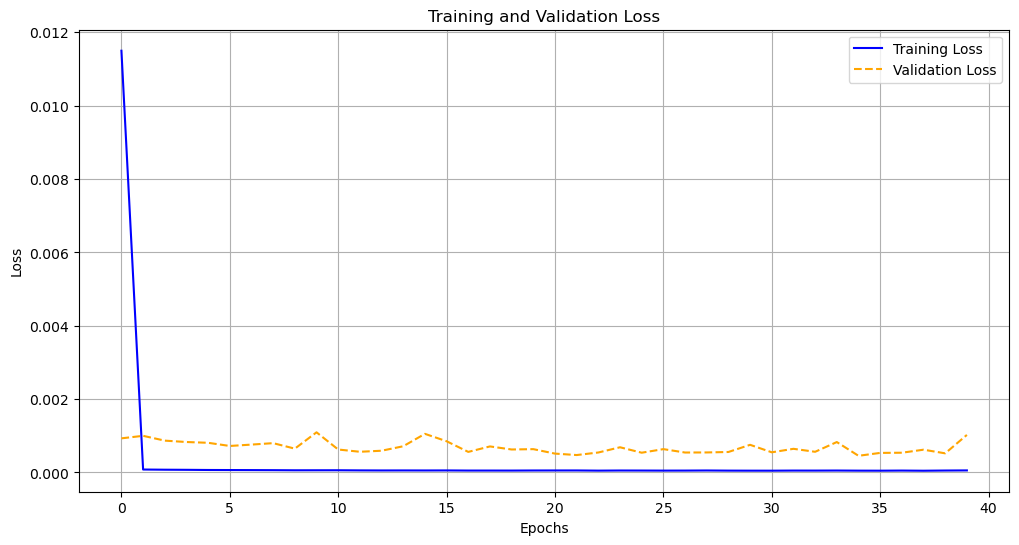

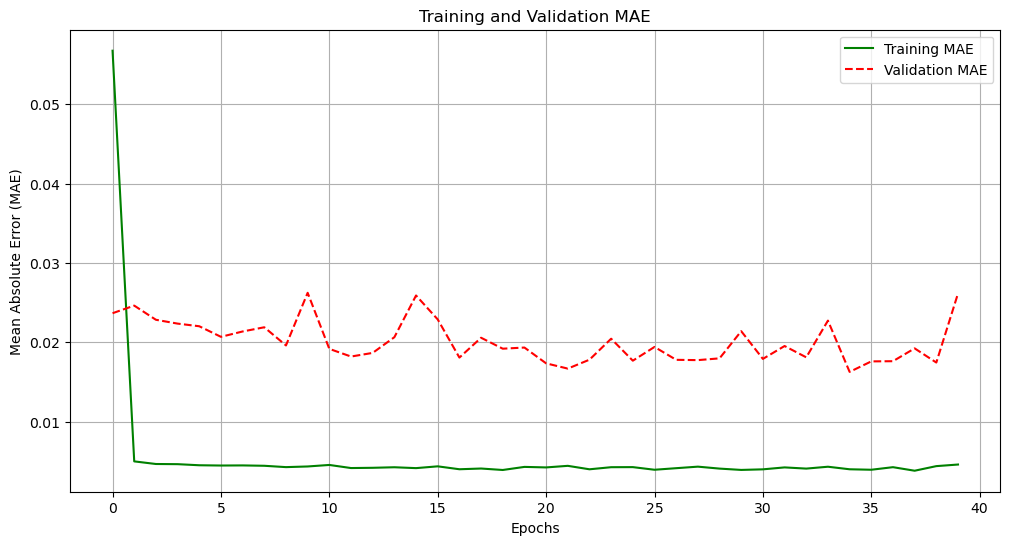

In [45]:
# Obtener los valores de pérdida (loss) y MAE (Mean Absolute Error) del entrenamiento y validación
loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']
mae = history_gru.history['mae']
val_mae = history_gru.history['val_mae']

# Crear la gráfica de pérdida
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', linestyle='--', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Crear la gráfica de MAE
plt.figure(figsize=(12, 6))
plt.plot(mae, label='Training MAE', color='green')
plt.plot(val_mae, label='Validation MAE', linestyle='--', color='red')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# Make predictions on the training set
y_train_pred_scaled = model_gru.predict(X_train_scaled)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)

# Make predictions on the test set
y_test_pred_scaled = model_gru.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

# Inverse transform the original values
y_train_original = scaler_y.inverse_transform(y_train_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Combine train and test predictions for visualization
train_time_steps = range(len(y_train_original))
test_time_steps = range(len(y_train_original), len(y_train_original) + len(y_test_original))


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


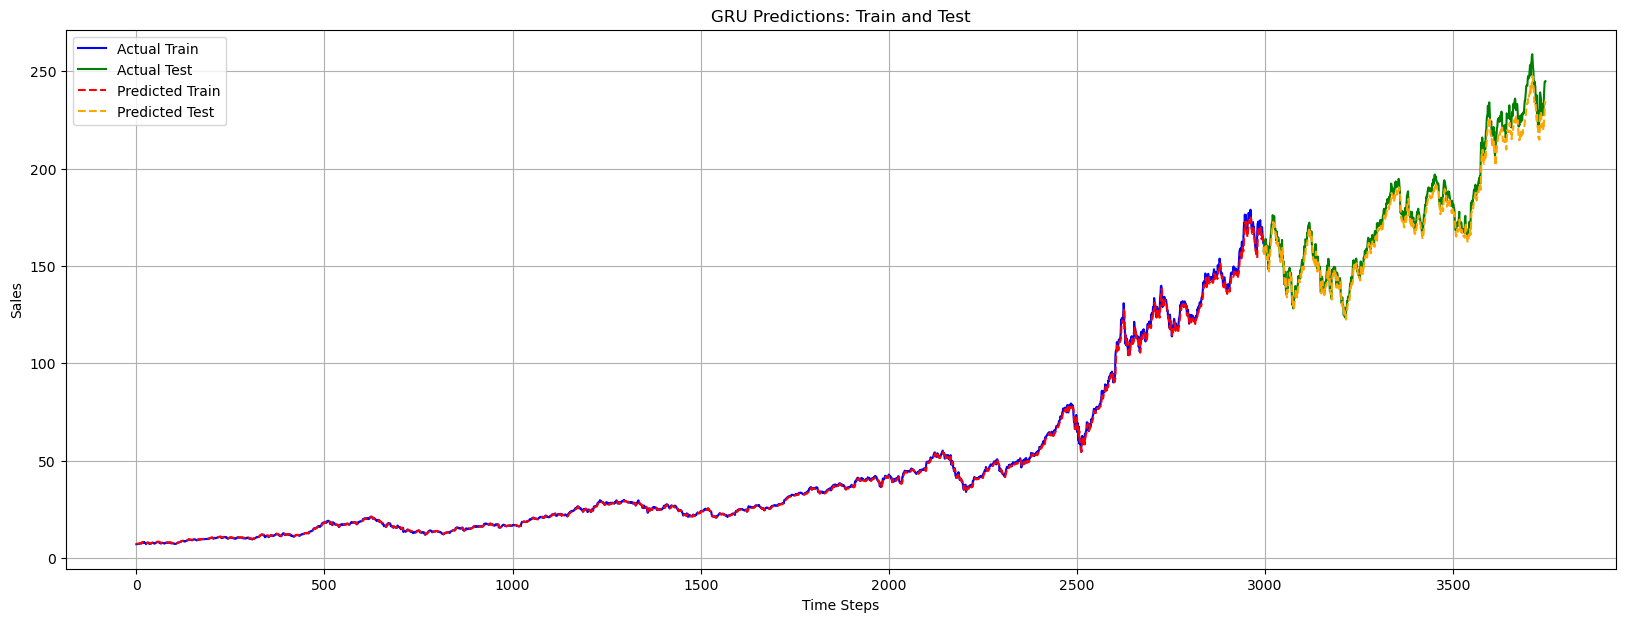

In [47]:
plt.figure(figsize=(20, 7))

# Plot actual values
plt.plot(train_time_steps, y_train_original, label="Actual Train", color="blue")
plt.plot(test_time_steps, y_test_original, label="Actual Test", color="green")

# Plot predictions
plt.plot(train_time_steps, y_train_pred, label="Predicted Train", color="red", linestyle="--")
plt.plot(test_time_steps, y_test_pred, label="Predicted Test", color="orange", linestyle="--")

# Customize the plot
plt.title("GRU Predictions: Train and Test")
plt.xlabel("Time Steps")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()

In [48]:
# Calculate metrics for training data
mape_train_gru = calculate_mape(y_train_original, y_train_pred)
mae_train_gru = calculate_mae(y_train_original, y_train_pred)
rmse_train_gru = calculate_rmse(y_train_original, y_train_pred)

# Calculate metrics for test data
mape_test_gru = calculate_mape(y_test_original, y_test_pred)
mae_test_gru = calculate_mae(y_test_original, y_test_pred)
rmse_test_gru= calculate_rmse(y_test_original, y_test_pred)

# Create a comparative table
metrics_data = {
    "Dataset": ["Train", "Test"],
    "MAPE (%)": [mape_train_gru, mape_test_gru],
    "MAE": [mae_train_gru, mae_test_gru],
    "RMSE": [rmse_train_gru, rmse_test_gru]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df

,Dataset,MAPE (%),MAE,RMSE
0,Train,1.590042,0.713388,1.333427
1,Test,2.394784,4.493249,5.497212


## Bidirectional LSTM Prediction

In [50]:
# Define the Bidirectional LSTM model
model_bi_lstm = Sequential([
    Bidirectional(
        LSTM(32, activation='tanh', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))
    ),  # Bidirectional LSTM layer
    Dense(1)  # Output layer
])

# Compile the model
model_bi_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

C:\Users\34636\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [51]:
model_bi_lstm.build(input_shape=(None, X_train_scaled.shape[1], X_train_scaled.shape[2]))
model_bi_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 64)             │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769 (34.25 KB)

 Trainable params: 8,769 (34.25 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Train the model
history_bi_lstm = model_bi_lstm.fit(
    X_train_scaled, y_train_scaled,  # Training data
    validation_data=(X_test_scaled, y_test_scaled),  # Validation data
    epochs=40,  # Number of epochs
    batch_size=32,  # Batch size
    verbose=1  # Display progress
)

Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0226 - mae: 0.0860 - val_loss: 0.0078 - val_mae: 0.0713
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.4996e-04 - mae: 0.0172 - val_loss: 0.0049 - val_mae: 0.0571
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.8629e-04 - mae: 0.0133 - val_loss: 0.0050 - val_mae: 0.0577
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.1597e-04 - mae: 0.0122 - val_loss: 0.0041 - val_mae: 0.0511
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.7113e-04 - mae: 0.0116 - val_loss: 0.0036 - val_mae: 0.0477
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.7583e-04 - mae: 0.0100 - val_loss: 0.0024 - val_mae: 0.0390
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.4998e-04 - mae: 0.0094 - val_loss: 0.0027 - val_mae: 0.0410
Epoch 8/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.6646e-04 - mae: 0.0097 - val_loss: 0.0018 - val_mae: 0.0340
Epoch 9/40
94/94 ━━━━━━━━━━━━━━━━━━━

In [53]:
# Evaluate the model on the test set
test_loss, test_mae = model_bi_lstm.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss (MSE): 0.0006
Test MAE: 0.0185


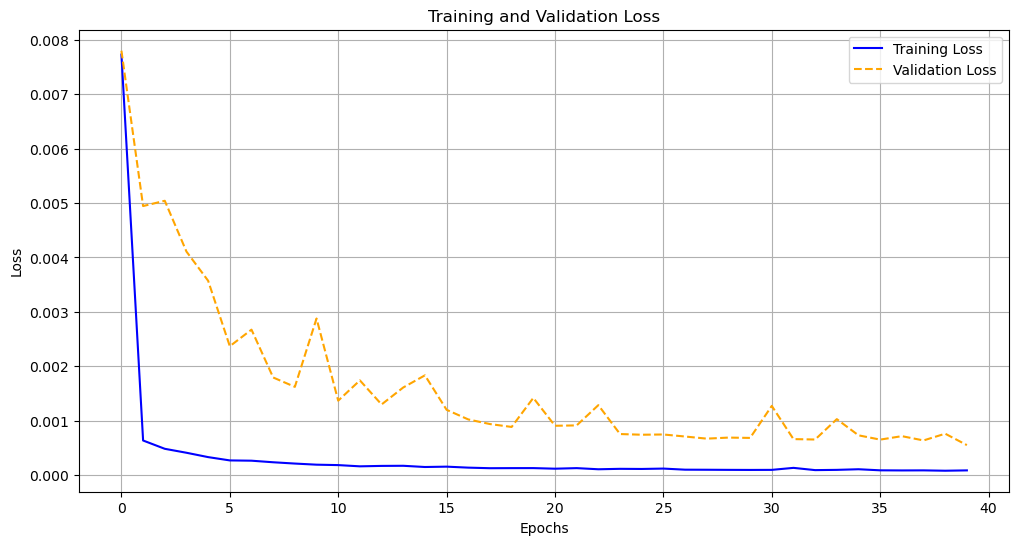

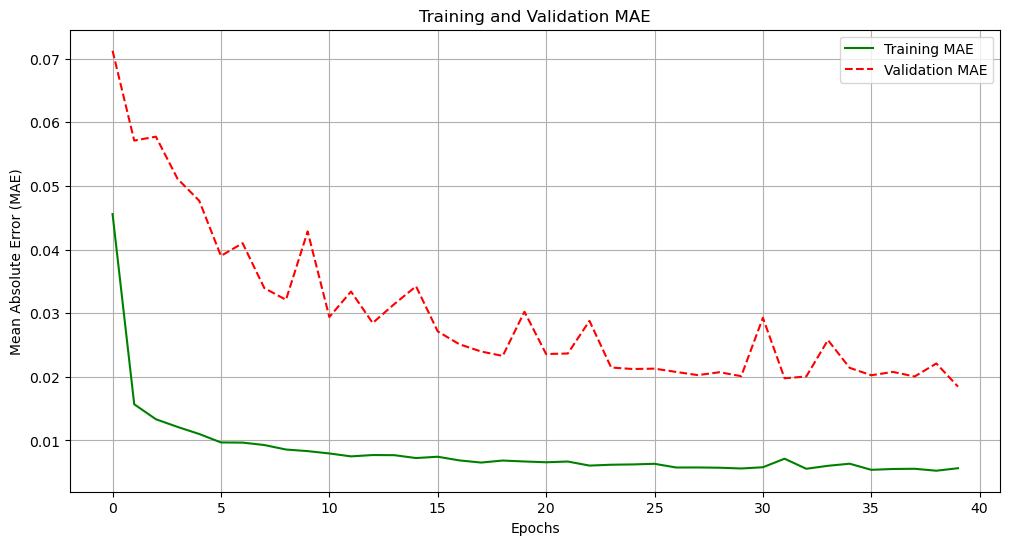

In [54]:
# Obtener los valores de pérdida (loss) y MAE (Mean Absolute Error) del entrenamiento y validación
loss = history_bi_lstm.history['loss']
val_loss = history_bi_lstm.history['val_loss']
mae = history_bi_lstm.history['mae']
val_mae = history_bi_lstm.history['val_mae']

# Crear la gráfica de pérdida
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', linestyle='--', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Crear la gráfica de MAE
plt.figure(figsize=(12, 6))
plt.plot(mae, label='Training MAE', color='green')
plt.plot(val_mae, label='Validation MAE', linestyle='--', color='red')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Make predictions on the training set
y_train_pred_scaled = model_bi_lstm.predict(X_train_scaled)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)

# Make predictions on the test set
y_test_pred_scaled = model_bi_lstm.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

# Inverse transform the original values
y_train_original = scaler_y.inverse_transform(y_train_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Combine train and test predictions for visualization
train_time_steps = range(len(y_train_original))
test_time_steps = range(len(y_train_original), len(y_train_original) + len(y_test_original))

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


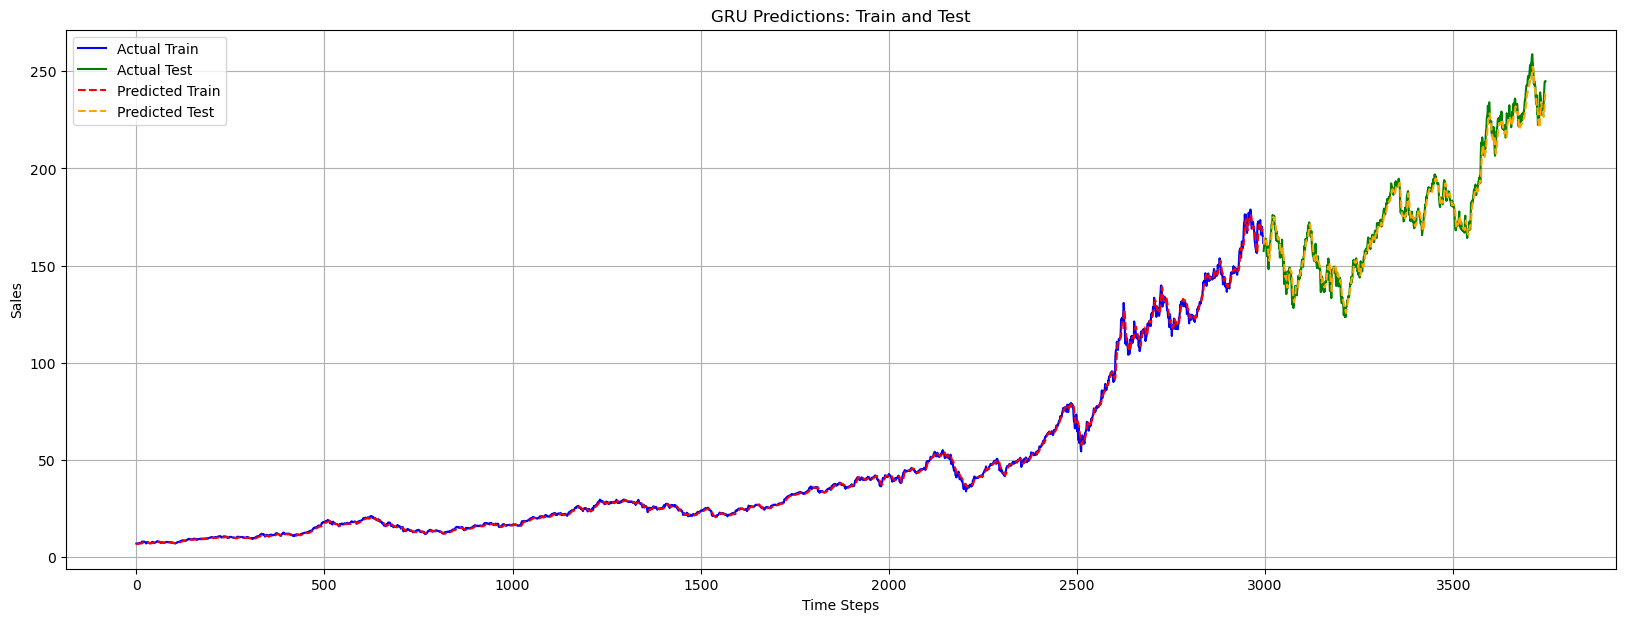

In [56]:
plt.figure(figsize=(20, 7))

# Plot actual values
plt.plot(train_time_steps, y_train_original, label="Actual Train", color="blue")
plt.plot(test_time_steps, y_test_original, label="Actual Test", color="green")

# Plot predictions
plt.plot(train_time_steps, y_train_pred, label="Predicted Train", color="red", linestyle="--")
plt.plot(test_time_steps, y_test_pred, label="Predicted Test", color="orange", linestyle="--")

# Customize the plot
plt.title("GRU Predictions: Train and Test")
plt.xlabel("Time Steps")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()

In [57]:
# Calculate metrics for training data
mape_train_bi_lstm = calculate_mape(y_train_original, y_train_pred)
mae_train_bi_lstm = calculate_mae(y_train_original, y_train_pred)
rmse_train_bi_lstm = calculate_rmse(y_train_original, y_train_pred)

# Calculate metrics for test data
mape_test_bi_lstm = calculate_mape(y_test_original, y_test_pred)
mae_test_bi_lstm = calculate_mae(y_test_original, y_test_pred)
rmse_test_bi_lstm= calculate_rmse(y_test_original, y_test_pred)

# Create a comparative table
metrics_data = {
    "Dataset": ["Train", "Test"],
    "MAPE (%)": [mape_train_bi_lstm, mape_test_bi_lstm],
    "MAE": [mae_train_bi_lstm, mae_test_bi_lstm],
    "RMSE": [rmse_train_bi_lstm, rmse_test_bi_lstm]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df

,Dataset,MAPE (%),MAE,RMSE
0,Train,2.195383,0.818373,1.432491
1,Test,1.783028,3.172182,4.031953


In [58]:
# Create a comparative table
metrics_data = {
    "Model": ["RNN", "LSTM", "GRU", "Bidirectional LSTM"],
    "MAPE (Train)": [mape_train, mape_train_lstm, mape_train_gru, mape_train_bi_lstm],
    "MAE (Train)": [mae_train, mae_train_lstm, mae_train_gru, mae_train_bi_lstm],
    "RMSE (Train)": [rmse_train, rmse_train_lstm, rmse_train_gru, rmse_train_bi_lstm],
    "MAPE (Test)": [mape_test, mape_test_lstm, mape_test_gru, mape_test_bi_lstm],
    "MAE (Test)": [mae_test, mae_test_lstm, mae_test_gru, mae_test_bi_lstm],
    "RMSE (Test)": [rmse_test, rmse_test_lstm, rmse_test_gru, rmse_test_bi_lstm]
}

metrics_comparative_df = pd.DataFrame(metrics_data)

metrics_comparative_df

,Model,MAPE (Train),MAE (Train),RMSE (Train),MAPE (Test),MAE (Test),RMSE (Test)
0,RNN,1.836397,0.752099,1.373017,2.771315,5.398296,7.406807
1,LSTM,2.443406,0.954626,1.644710,2.296474,4.193285,5.284980
2,GRU,1.590042,0.713388,1.333427,2.394784,4.493249,5.497212
3,Bidirectional LSTM,2.195383,0.818373,1.432491,1.783028,3.172182,4.031953
